In [1]:
import deepcompton
import os
import numpy as np
import matplotlib.pyplot as plt
print(os.getcwd())

data_dir = "../save_Compton"
if not os.path.exists(data_dir):
    print("Could not find data directory {}".format(data_dir))

/home/aschulz/Documents/python/astroinfo2021/compton-hackathon/DeepIntegralCompton/examples


In [2]:
# instrument caracteristics
z_isgri = 0.
z_picsit = -8.68

In [3]:
# first we need to create the dataset used for training and testing
from deepcompton.cones import make_cone_density
def make_dataset(datadir, max_n = 1000):
    y,x=[],[]
    for f in os.listdir(datadir):
        _,theta,_,phi=f.replace(".npy","").split("_")
        data = make_cone_density(theta, phi, z_isgri, z_picsit, datadir=datadir, progress=False)
        if data is not None:
            y.append([float(theta),float(phi)])
            x.append(data.reshape(180,45,1))
        if len(y)==max_n:
            break
        print(len(y))
    return np.array(x),np.array(y)
# pickled data
pkl_filename = "../cone_density_data_full.pkl"
if os.path.exists(pkl_filename):
    import pickle as pkl
    fdata=pkl.load(open(pkl_filename,"rb"))
    x=[e[1] for e in fdata]
    y=[e[0] for e in fdata]
    def clean_pkl_data(x,y):
        a,b=[],[]
        for i in range(len(x)):
            if x[i] is not None:
                a.append(x[i].reshape(180,45,1))
                b.append(np.array([float(y[i][0]),float(y[i][1])]))
        return np.array(a),np.array(b)
    x,y = clean_pkl_data(x,y)
    
else:
    x,y = make_dataset(data_dir)
    pkl.dump((x,y),open(pkl_filename,"wb"))
print(x.shape, y.shape)

(3715, 180, 45, 1) (3715, 2)


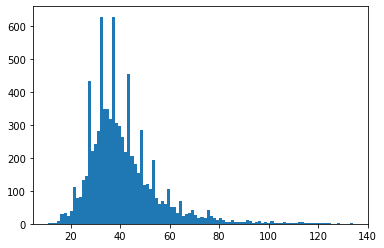

In [4]:
# plot the distribution of the data
plt.figure()
plt.hist(x[0].flatten(),bins=100)
plt.show()

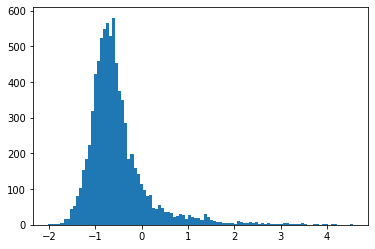

In [5]:
# normalize the data
from sklearn.preprocessing import scale
flat_x=[]
for i in range(x.shape[0]):
    flat_x.append(x[i].flatten())
flat_x=np.array(flat_x)


flat_x = scale(flat_x)

new_x = [flat_x[i].reshape(180,45,1) for i in range(flat_x.shape[0])]
new_x = np.array(new_x)
plt.figure()
plt.hist(new_x[0].flatten(),bins=100)
plt.show()

In [6]:
#from deepcompton.vizualisation import plot_backprojected
#plot_backprojected(y[0,0],y[0,1], x[0])

In [7]:
# creating the train and test data
from sklearn.model_selection import train_test_split
import tensorflow as tf
x_train,x_test, y_train,y_test = train_test_split(new_x, y, shuffle=True)

y_train,y_test = np.array(y_train), np.array(y_test)
x_train,x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# convert to tensorflow tensors
y_train = tf.convert_to_tensor(y_train)
x_train = tf.convert_to_tensor(x_train)
#y_test= tf.convert_to_tensor(y_test)
#x_test= tf.convert_to_tensor(x_test)
print("Train data : {} {}".format(x_train.shape, y_train.shape))
print("Test data  : {} {}".format(x_test.shape, y_test.shape))


2021-12-08 06:44:21.689341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 06:44:21.689383: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(2786, 180, 45, 1) (2786, 2) (929, 180, 45, 1) (929, 2)
Train data : (2786, 180, 45, 1) (2786, 2)
Test data  : (929, 180, 45, 1) (929, 2)


2021-12-08 06:44:24.723260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-08 06:44:24.723305: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-08 06:44:24.723336: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mademu): /proc/driver/nvidia/version does not exist
2021-12-08 06:44:24.724048: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# definition of a first convolutional model
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Flatten
def get_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(32,3,input_shape=(180,45,1), activation="elu"))
    model.add(BatchNormalization())
    #model.add(Conv2D(64,3, activation="elu"))
    #model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512,activation="elu"))
    model.add(BatchNormalization())
    #model.add(Dense(128,activation="relu"))
    #model.add(BatchNormalization())
    model.add(Dense(2, activation="elu"))
    return model

In [9]:
from deepcompton.utils import angular_separation
def angular_loss(y_true, y_pred):
    # convert to rad
    _deg2rad = np.pi / 180.
    _lat1,_lon1=y_true[-1][0]*_deg2rad,y_true[-1][1]*_deg2rad
    _lat2,_lon2=y_pred[-1][0]*_deg2rad,y_pred[-1][1]*_deg2rad
    return -1. * (tf.math.sin(_lat1)*tf.math.sin(_lat2)*
                  tf.math.cos(_lon1-_lon2)+
                  tf.math.cos(_lat2)*tf.math.cos(_lat1))
    

In [10]:
# create the model
model = get_model()

2021-12-08 06:44:38.082167: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 501612544 exceeds 10% of free system memory.
2021-12-08 06:44:38.392794: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 501612544 exceeds 10% of free system memory.
2021-12-08 06:44:38.451705: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 501612544 exceeds 10% of free system memory.


In [11]:
epochs = 100
batch_size = 12

callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    tf.keras.callbacks.TensorBoard('./logs/density_cnn_1_mse_1layer_lr1e-2'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]



model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-2),
    loss="mean_squared_error",
    metrics=["mean_squared_error"],
    #loss=angular_loss,
    #metrics=[angular_loss],
)

In [12]:
model.fit(
    x_train, y_train, 
    #steps_per_epoch=epochs,
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_split = 0.2,
)

Epoch 1/100


2021-12-08 06:44:49.242850: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 501612544 exceeds 10% of free system memory.
2021-12-08 06:44:49.299125: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 501612544 exceeds 10% of free system memory.


186/186 [==============================] - 151s 808ms/step - loss: 5086.4521 - mean_squared_error: 5086.4521 - val_loss: 2329.4407 - val_mean_squared_error: 2329.4407
Epoch 2/100
186/186 [==============================] - 171s 920ms/step - loss: 1522.9954 - mean_squared_error: 1522.9954 - val_loss: 875.4266 - val_mean_squared_error: 875.4266
Epoch 3/100
186/186 [==============================] - 162s 873ms/step - loss: 1235.5234 - mean_squared_error: 1235.5234 - val_loss: 844.5901 - val_mean_squared_error: 844.5901
Epoch 4/100
186/186 [==============================] - 144s 771ms/step - loss: 1106.6581 - mean_squared_error: 1106.6581 - val_loss: 967.0216 - val_mean_squared_error: 967.0216
Epoch 5/100
186/186 [==============================] - 124s 665ms/step - loss: 1169.1946 - mean_squared_error: 1169.1946 - val_loss: 1080.8403 - val_mean_squared_error: 1080.8403
Epoch 6/100
186/186 [==============================] - 123s 659ms/step - loss: 899.4698 - mean_squared_error: 899.4698 - va

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1012.2693481445312
Test accuracy: 1012.2693481445312


/home/aschulz/Documents/python/astroinfo2021/compton-hackathon/DeepIntegralCompton/deepcompton/vizualisation.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tt)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[ 60.790504 244.78494 ]]
[ 68. 300.]


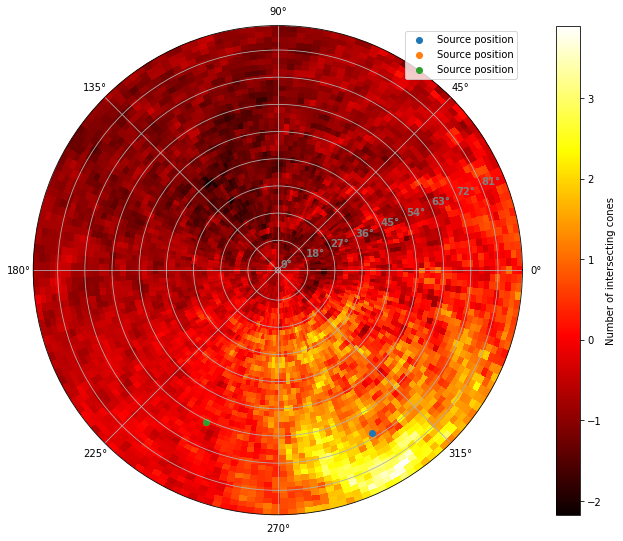

In [14]:
from deepcompton.vizualisation import plot_backprojected,plot_source_pos
i=10

actual = np.radians(np.linspace(0,360, 180))
expected = np.arange(0,90,2)
r_g, theta_g = np.meshgrid(expected, actual)
ax = plot_backprojected(theta_g, r_g, x_test[i].reshape(180,45))
ax = plot_source_pos(y_test[i,0], np.radians(y_test[i,1]), ax=ax)
pred = model(tf.reshape(x_test[i],[1,180,45,1]))
print(pred.numpy())
print(y_test[i])
ax = plot_source_pos(pred[0,0], np.radians(pred[0,1]), ax=ax)
ax = plot_source_pos(pred[0,0], np.radians(pred[0,1]), ax=ax)


Mean angular separation : 18.44491082043652


Text(0.5, 0, 'Angular separation (deg)')

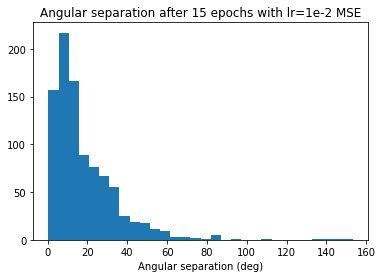

In [15]:
pred = model(x_test).numpy()
from deepcompton.utils import angular_separation
# compute angular separation
y_real_rad = y_test * np.pi / 180.
y_pred_rad = pred * np.pi / 180.

angular_seps=angular_separation(y_real_rad[:,0],y_real_rad[:,1],
                               y_pred_rad[:,0],y_pred_rad[:,1]) * 180. / np.pi

plt.figure()
plt.hist(angular_seps, bins=30)
print("Mean angular separation : {}".format(np.mean(angular_seps)))
plt.title("Angular separation after 15 epochs with lr=1e-2 MSE")
plt.xlabel("Angular separation (deg)")